#Обработка текстов нейронными сетями: классификация обращений граждан

##Импорт библиотек

In [1]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Загрузка датасета и подготовка данных

In [2]:
# Загрузка данных из файла в таблицу
df = pd.read_csv('/content/drive/MyDrive/data_vid.csv')

In [3]:
# Вывод первых строк таблицы
df

,Unnamed: 0,count,hour+,viewer_uid,age,age_class,author_id,title,category,duration,sex_n,ua_device_type_n,ua_client_type_n,year,month,day,time,weekday,hour
0,0,1787982,0,10288257,48,3,1010824,#МОНТЯН В ЭФИРЕ: С Грубником на связи 😉,Интервью,12196012,0,0,2,2024,6,6,3,3,14
1,1,1787982,0,10736308,23,1,1007611,ОБРАТНАЯ ФУНКЦИЯ Что это?! | Тригонометрия в Е...,Обучение,429917,1,2,1,2024,6,24,0,0,23
2,2,1787982,0,10050652,48,3,1043618,"Ход королевы 7 серия «Эндшпиль» (сериал, 2020)",Сериалы,4072736,0,2,2,2024,6,9,6,6,15
3,3,1787982,0,10050652,48,3,1043618,"Ход королевы 2 серия «Размены» (сериал, 2020)",Сериалы,3912609,0,2,2,2024,6,9,6,6,15
4,4,1787982,0,10051529,39,2,1005481,"Экстрасенсы. Битва сильнейших, 2 сезон, 8 выпу...",Телепередачи,4000000,0,0,2,2024,6,2,6,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,1759611,109,0,10013408,38,2,1008828,«За гранью»: «Мускулистая невеста» | Выпуск от...,Телепередачи,3000920,1,0,2,2024,6,29,5,5,13
1759612,1759612,109,0,10013408,38,2,1008828,«За гранью»: «Любовь за миллионы» | Выпуск от ...,Телепередачи,3005400,1,0,2,2024,6,29,5,5,17
1759613,1759613,109,0,10013408,38,2,1008828,«За гранью»: «Проспали младенца?» | Выпуск от ...,Телепередачи,3027320,1,0,2,2024,6,29,5,5,12
1759614,1759614,109,0,10013408,38,2,1008828,«За гранью»: «Экстремальная старость» | Выпуск...,Телепередачи,3013040,1,0,2,2024,6,29,5,5,18


##Модель на наборе данных без балансировки и фильтрации

In [3]:
# Функция вывода сводки по распределению данных
def data_summary(df, age_class):
    for cls in age_class:  # sex_n:
        print(f'Количество записей класса {cls}: {df[df.age_class == cls].shape[0]}')

In [4]:
# Сводка по распределению данных
data_summary(df, df.age_class.unique())

Количество записей класса 3: 365765
Количество записей класса 1: 653757
Количество записей класса 2: 673797
Количество записей класса 0: 66297


In [4]:
# Назначение интервала допустимого количества текстов по классу
text_count_interval = [25000, 26000]

# Фильтрация данных - отбрасываются все данные без категории
# и все классы объемом менее нижней границы разрешенного интервала
class_to_drop = ['нет данных']
for cls in df.age_class.unique():
    if df[df.age_class == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)

print(f'Удаляются классы: {class_to_drop}')

del_mask = df.age_class.isin(class_to_drop)
df = df[~del_mask]

# По всем оставшимся классам количество примеров ограничивается не более
# верхней границы разрешенного интервала
for cls in df.age_class.unique():
    df = df.drop(df[df.age_class == cls].index[text_count_interval[1]:])

Удаляются классы: ['нет данных']


###Преобразование текстовых данных в числовые и векторные представления для обучения нейросети

In [5]:
# Задание параметров преобразования
VOCAB_SIZE       = 2000                  # Объем словаря для токенизатора
TRAIN_TEST_RATIO = 0.2                    # Доля проверочной выборки в основном наборе

**Токенизация и преобразование в последовательности**

In [6]:
# Извлечение всех записей-текстов обращений и их меток классов
text_data = df.title.tolist()
class_data = df.age_class.tolist()

In [7]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

In [8]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря: {len(items)}')
print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Размер словаря: 30863
Список классов: [0 1 2 3]
Всего классов: 4
Форма выходных данных: (104000,)
Пример числовых меток классов: [3 1 3 3 2 2 2 2 2 2]


In [9]:
# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
# Вывод формы и примера данных
print(x_data.shape)
print(x_data[0][:20])

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print(x_data_01.shape)
print(x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print(y_data.shape)
print(y_data[0])

(104000,)
[396, 6, 675, 26, 1, 19, 1558, 1]
(104000, 2000)
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(104000, 4)
[0. 0. 0. 1.]


**Создание обучающей и тестовой выборок**

In [10]:
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

# Разделение в соответствии с полученными индексами
x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print(x_train.shape, x_test.shape)
print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(83200,) (20800,)
(83200, 2000) (20800, 2000)
(83200, 4) (20800, 4)


###Сервисные функции


In [11]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(6, 6)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

### BagOfWords + Dense

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │         200,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,704 (862.12 KB)

 Trainable params: 220,704 (862.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.3560 - loss: 1.3199 - val_accuracy: 0.4256 - val_loss: 1.2411
Epoch 2/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4262 - loss: 1.2380 - val_accuracy: 0.4359 - val_loss: 1.2221
Epoch 3/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4391 - loss: 1.2149 - val_accuracy: 0.4392 - val_loss: 1.2122
Epoch 4/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4520 - loss: 1.1955 - val_accuracy: 0.4427 - val_loss: 1.2090
Epoch 5/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4580 - loss: 1.1845 - val_accuracy: 0.4464 - val_loss: 1.2046
Epoch 6/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4605 - loss: 1.1765 - val_accuracy: 0.4482 - val_loss: 1.2017
Epoch 7/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4633 - loss: 1.1685 - val_accuracy: 0.4468 - val_loss: 1.2018
Epoch 8/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4674 - loss: 1.1627

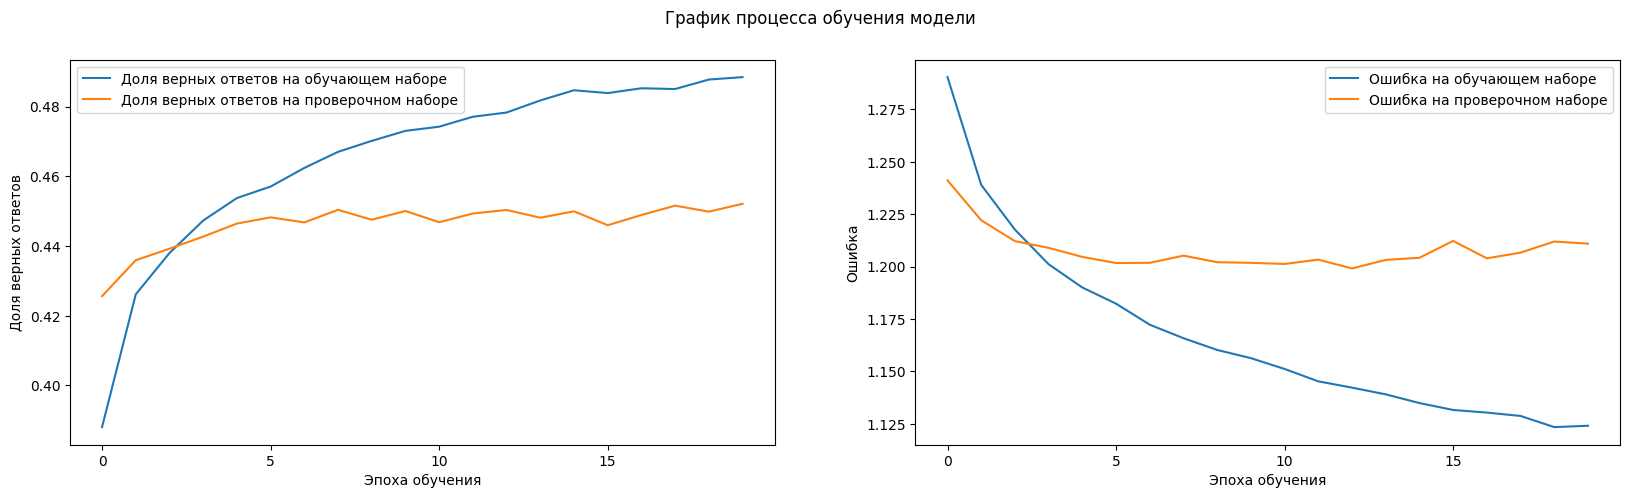

650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


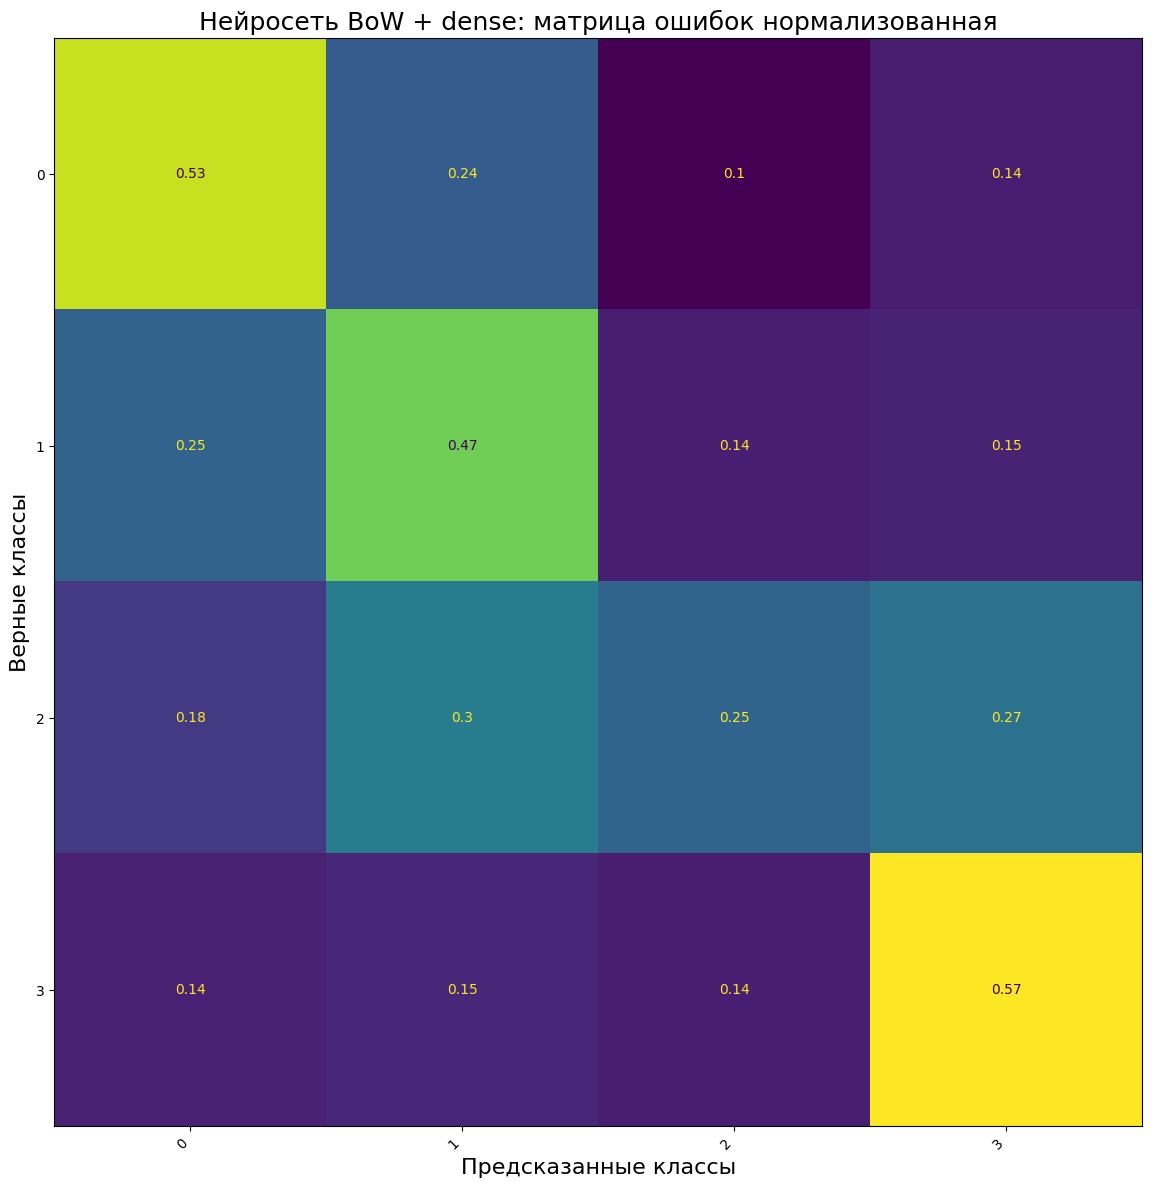

----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: 0                     53% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     46% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 2                     30% сеть отнесла к классу 1                    - НЕВЕРНО :-(
Класс: 3                     57% сеть отнесла к классу 3                    - ВЕРНО :-)

Средняя точность распознавания:  45%


In [12]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

**Выводы по обучению модели BagOfWords + Dense**

### Embedding + Dense

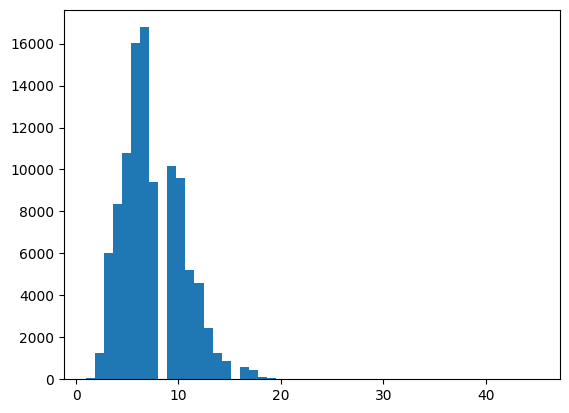

In [13]:
# Построение гистограммы распределения длин текстов основного набора
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

In [14]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 2400
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(83200, 2400) (20800, 2400)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.2853 - loss: 1.5306 - val_accuracy: 0.3821 - val_loss: 1.2895
Epoch 2/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.3797 - loss: 1.2904 - val_accuracy: 0.3573 - val_loss: 1.3125
Epoch 3/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4056 - loss: 1.2633 - val_accuracy: 0.4172 - val_loss: 1.2499
Epoch 4/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4172 - loss: 1.2453 - val_accuracy: 0.4015 - val_loss: 1.2564
Epoch 5/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4253 - loss: 1.2319 - val_accuracy: 0.4338 - val_loss: 1.2345
Epoch 6/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.4379 - loss: 1.2147 - val_accuracy: 0.4373 - val_loss: 1.2244
Epoch 7/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4436 - loss: 1.2041 - val_accuracy: 0.4338 - val_loss: 1.2233
Epoch 8/20
2600/2600 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4507 - loss: 1

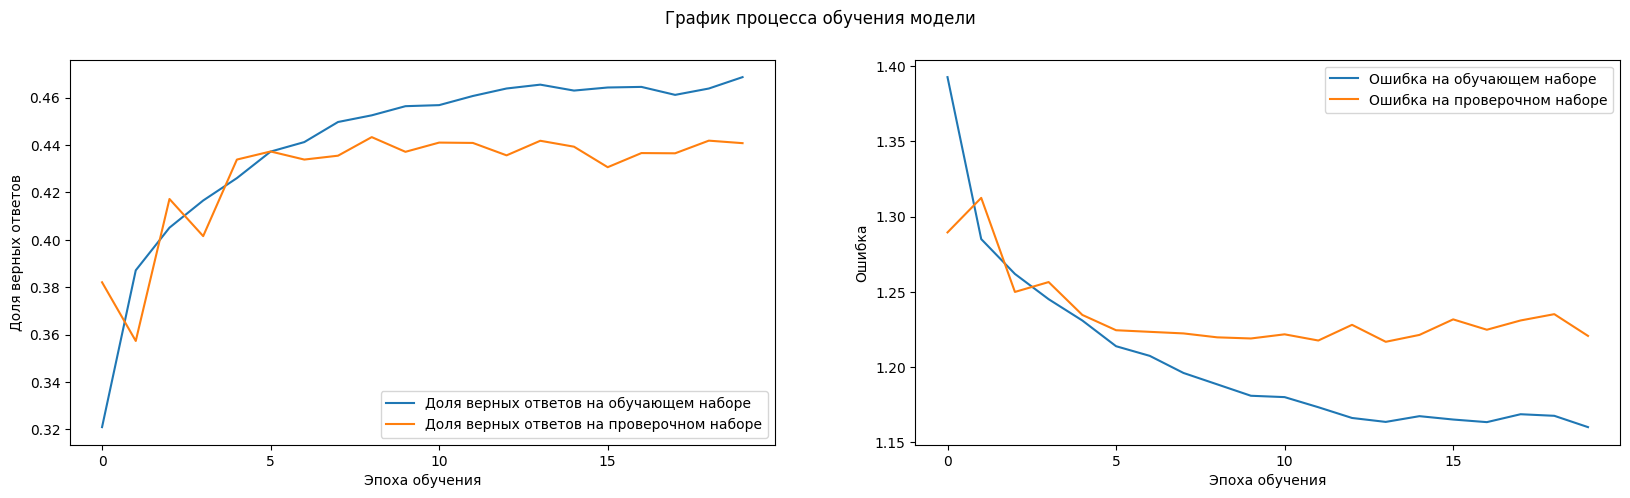

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


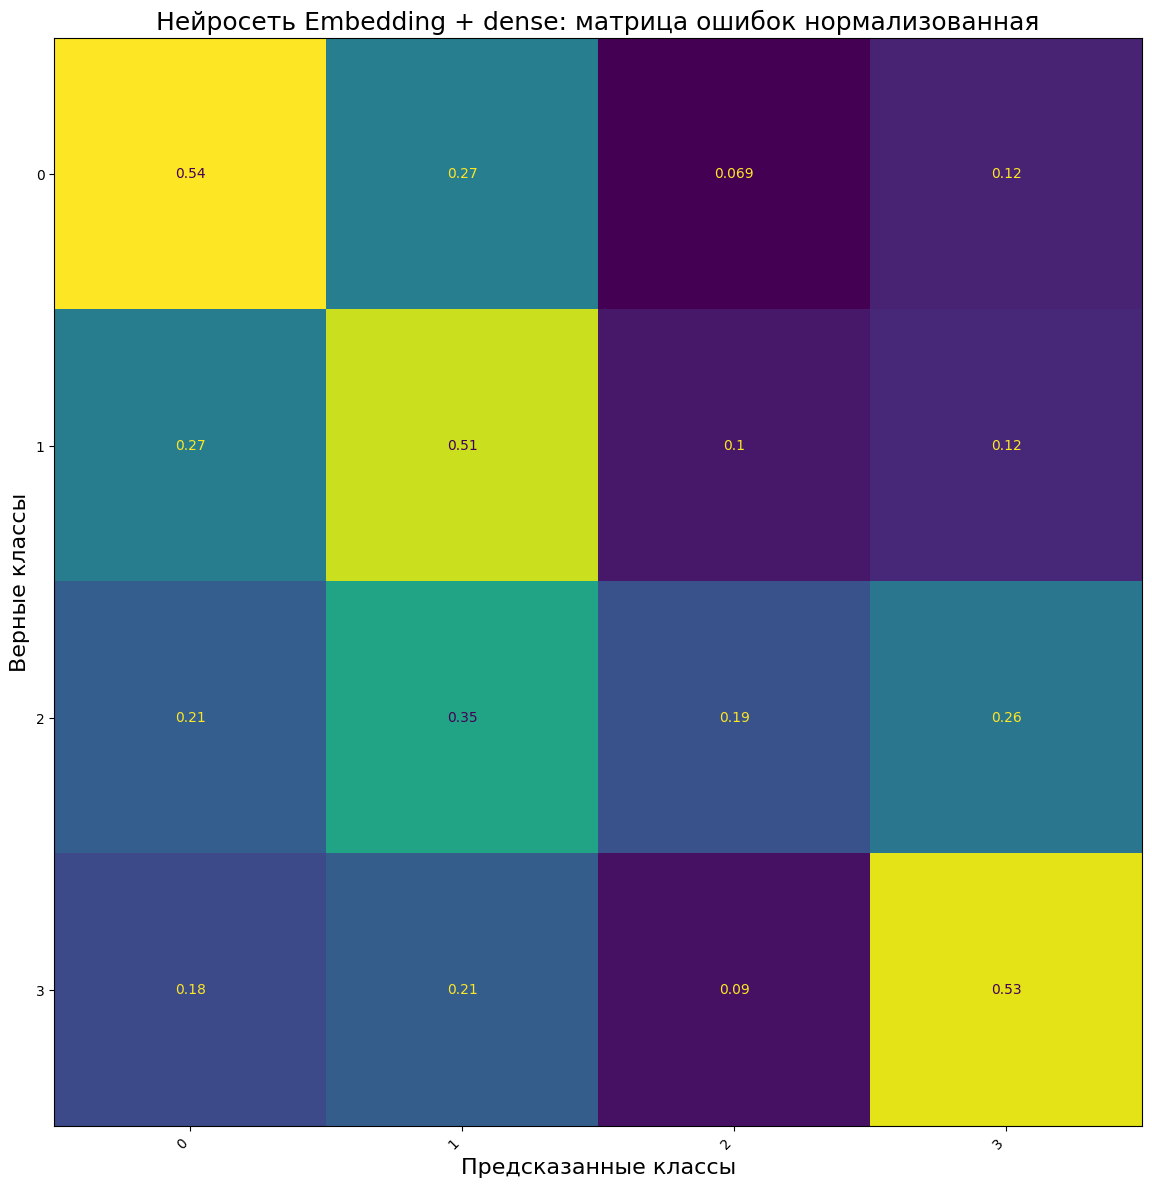

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding + dense
Класс: 0                     54% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     51% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 2                     35% сеть отнесла к классу 1                    - НЕВЕРНО :-(
Класс: 3                     52% сеть отнесла к классу 3                    - ВЕРНО :-)

Средняя точность распознавания:  44%


In [15]:
# Последовательная модель
model_text_emb_dense = Sequential()
# Cлой эмбеддингов
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
# Слой регуляризации Dropout
model_text_emb_dense.add(SpatialDropout1D(0.2))
# Cлой преобразования многомерных данных в одномерные
model_text_emb_dense.add(Flatten())
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Полносвязный слой
model_text_emb_dense.add(Dense(64, activation="relu"))
# Слой регуляризации Dropout
model_text_emb_dense.add(Dropout(0.2))
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Выходной полносвязный слой
model_text_emb_dense.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_dense,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='Embedding + dense')

**Выводы по обучению модели Embedding + Dense**

##Модель на отфильтрованном и сбалансированном наборе данных

---



###Фильтрация и балансировка данных

Сперва взгляните на статистику по категориям вашей базы данных.

В этом вам поможет
первоначальная функция `data_summary()`:

In [16]:
# Сводка по распределению данных в порядке кодированных меток
data_summary(df, CLASS_LIST)

Количество записей класса 0: 26000
Количество записей класса 1: 26000
Количество записей класса 2: 26000
Количество записей класса 3: 26000


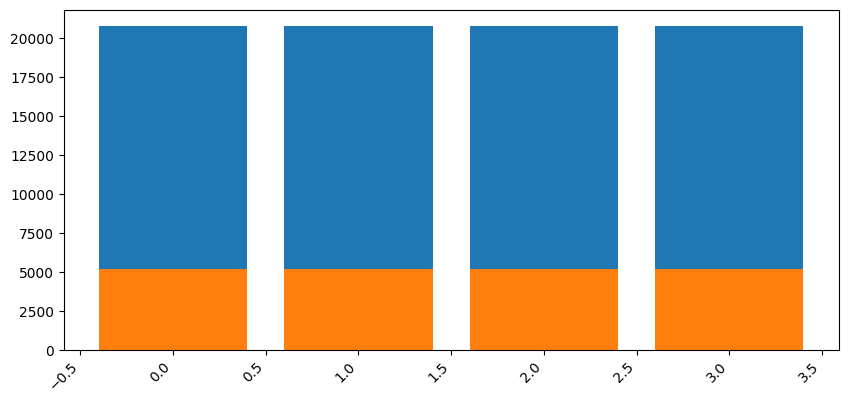

In [17]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = np.bincount(np.argmax(y_train, axis=1))
c_test = np.bincount(np.argmax(y_test, axis=1))
plt.bar(CLASS_LIST, c_train)
plt.bar(CLASS_LIST, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

In [18]:
# Назначение интервала допустимого количества текстов по классу
text_count_interval = [600, 600]

# Фильтрация данных - отбрасываются все данные без категории
# и все классы объемом менее нижней границы разрешенного интервала
class_to_drop = ['нет данных']
for cls in df.age_class.unique():
    if df[df.age_class == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)

print(f'Удаляются классы: {class_to_drop}')

del_mask = df.age_class.isin(class_to_drop)
df = df[~del_mask]

# По всем оставшимся классам количество примеров ограничивается не более
# верхней границы разрешенного интервала
for cls in df.age_class.unique():
    df = df.drop(df[df.age_class == cls].index[text_count_interval[1]:])

Удаляются классы: ['нет данных']


Сравните получившуюся базу с исходной! Другое дело, ведь сейчас вы можете
рассчитывать на большую точность работы НС, хотя и пожертвовали для этого рядом
категорий.

In [19]:
data_summary(df, df.age_class.unique())

Количество записей класса 3: 600
Количество записей класса 1: 600
Количество записей класса 2: 600
Количество записей класса 0: 600


**Токенизация и преобразование в последовательности**

Блоки кода ниже повторяют уже рассмотренные вами операции по предобработке данных,
только теперь вы работаете с новой сбалансированной базой:

In [20]:
# Извелечение всех записей-текстов обращений и их меток классов
text_data = df.title.tolist()
class_data = df.age_class.tolist()

In [21]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

In [22]:
# Кодирование меток классов индексами (числами)
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря: {len(items)}')
print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')
print(f'Пример числовых меток классов: {class_labels[:10]}')

Размер словаря: 3694
Список классов: [0 1 2 3]
Всего классов: 4
Форма выходных данных: (2400,)
Пример числовых меток классов: [3 1 3 3 2 2 2 2 2 2]


В статистике, приведенной выше, еще раз взгляните на количество оставшихся классов
(категорий). Теперь их 10.

Далее все действия по обработке и подготовке данных в точности повторяются с
использованными ранее. Для ускорения процесса можете даже просто скопировать
предыдущие блоки, ведь все имена переменных и операции совпадают.

In [23]:
# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype=object)
# Вывод формы и примера данных
print(x_data.shape)
print(x_data[0][:20])

# Преобразование входных текстов в разреженную матрицу из векторов Bag of Words
x_data_01 = tokenizer.texts_to_matrix(text_data)
# Вывод формы и примера данных
print(x_data_01.shape)
print(x_data_01[0, :20])

# Преобразование меток класса к векторам one hot encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
# Вывод формы и примера данных
print(y_data.shape)
print(y_data[0])

(2400,)
[235, 6, 300, 23, 855, 15, 639, 856]
(2400, 2000)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2400, 4)
[0. 0. 0. 1.]


**Создание обучающей и проверочной выборки**

In [24]:
# Получение индексов разделения основного набора на обучающую и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

# Разделение в соответствии с полученными индексами
x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print(x_train.shape, x_test.shape)
print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)

(1920,) (480,)
(1920, 2000) (480, 2000)
(1920, 4) (480, 4)


И снова обратитесь к гистограмме объема данных по каждой категории. Теперь вы
наглядно убедитесь, что количество обращений граждан по каждой категории
упорядочено.

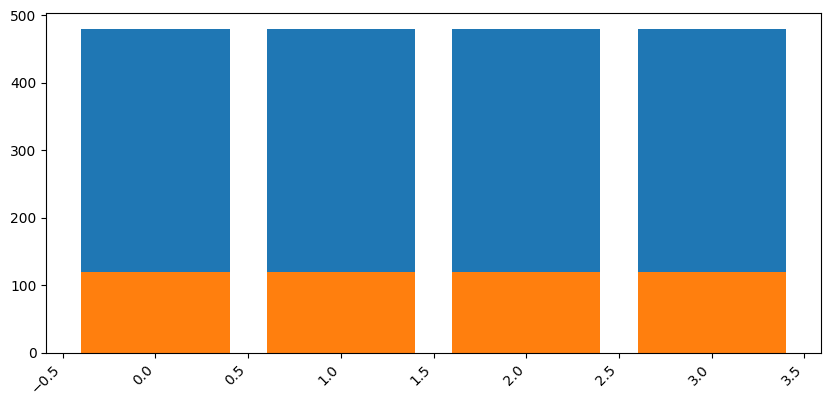

In [25]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = np.bincount(np.argmax(y_train, axis=1))
c_test = np.bincount(np.argmax(y_test, axis=1))
plt.bar(CLASS_LIST, c_train)
plt.bar(CLASS_LIST, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

### BagOfWords + Dense

Вы почти закончили, осталось поэкспериментировать с обучением прежних моделей НС
на обновленных данных. Теперь модель предсказывает принадлежность обращения
гражданина в пределах десяти категорий. Перед вами архитектура и дальнейшее обучение
модели *BagOfWords + Dense*:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 100)                 │         200,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,704 (862.12 KB)

 Trainable params: 220,704 (862.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3237 - loss: 1.3738 - val_accuracy: 0.4688 - val_loss: 1.2833
Epoch 2/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5513 - loss: 1.1435 - val_accuracy: 0.5604 - val_loss: 1.0555
Epoch 3/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.7611 - val_accuracy: 0.5688 - val_loss: 1.0380
Epoch 4/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7413 - loss: 0.6475 - val_accuracy: 0.5500 - val_loss: 1.1000
Epoch 5/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.5359 - val_accuracy: 0.5792 - val_loss: 1.1440
Epoch 6/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7805 - loss: 0.5021 - val_accuracy: 0.5604 - val_loss: 1.2497
Epoch 7/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7966 - loss: 0.4731 - val_accuracy: 0.5667 - val_loss: 1.2510
Epoch 8/64
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.4311 - val_accuracy: 0.5750 - val_loss

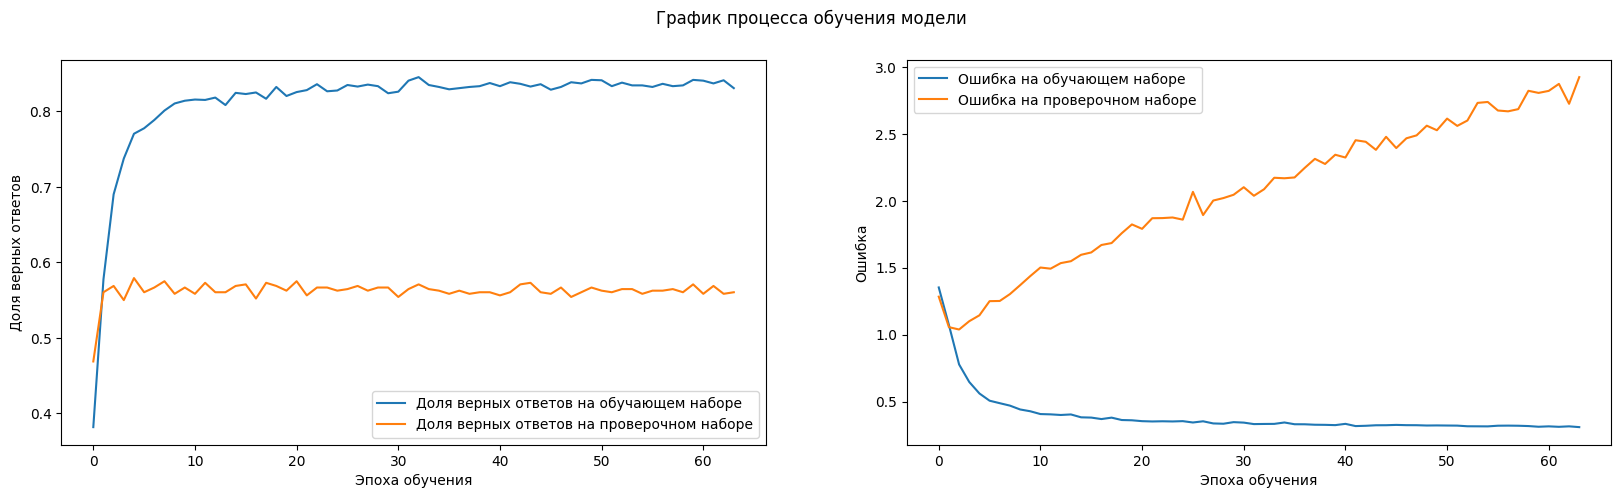

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


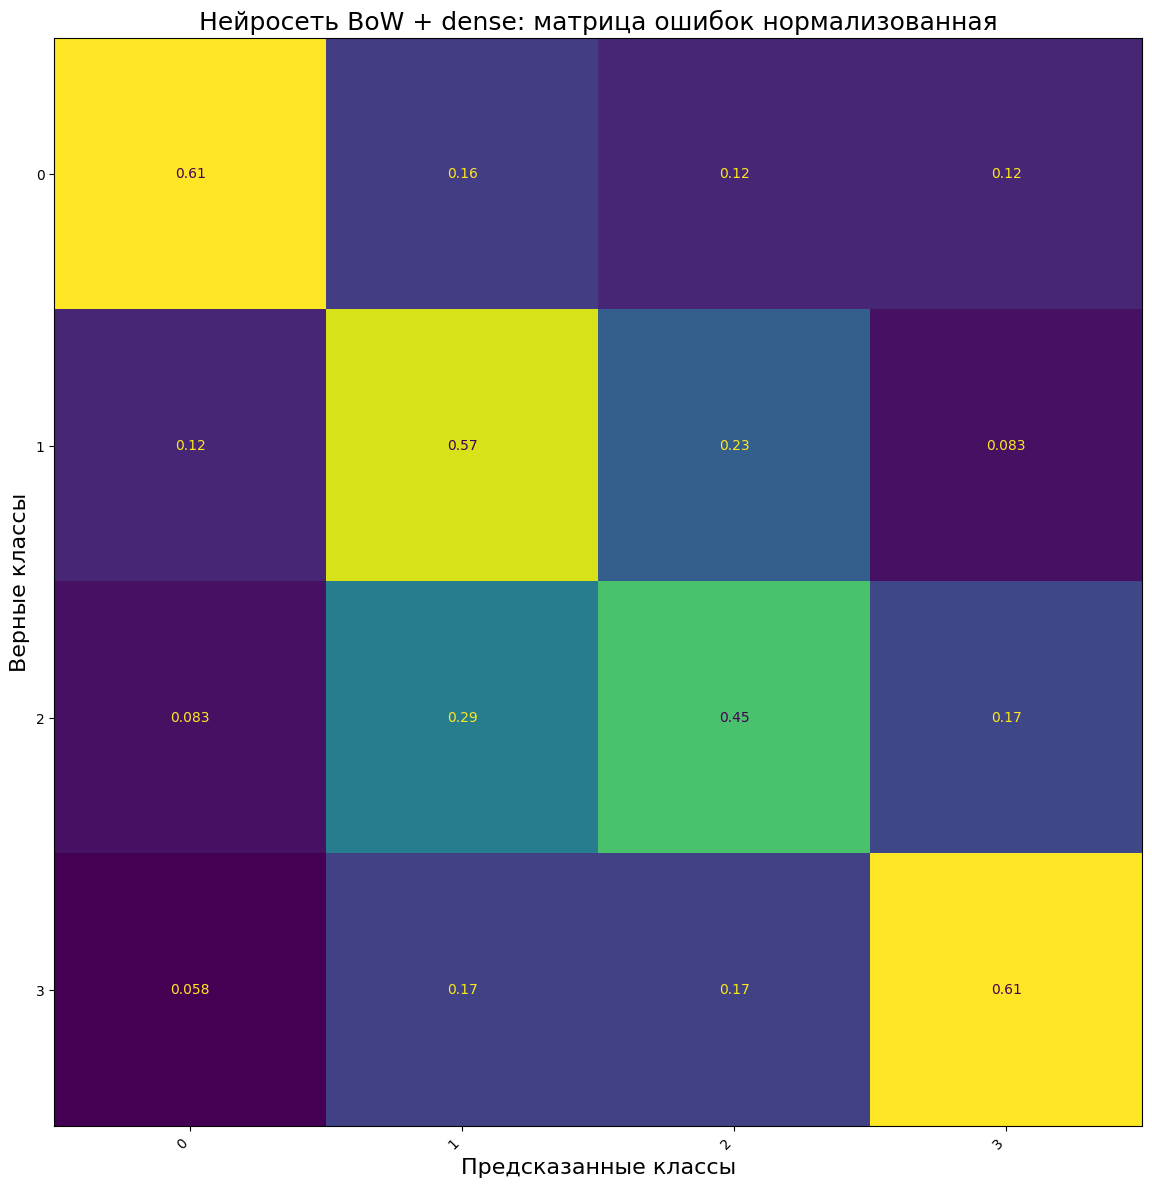

----------------------------------------------------------------------------------------------------
Нейросеть: BoW + dense
Класс: 0                     61% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     57% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 2                     45% сеть отнесла к классу 2                    - ВЕРНО :-)
Класс: 3                     61% сеть отнесла к классу 3                    - ВЕРНО :-)

Средняя точность распознавания:  56%


In [26]:
# Последовательная модель
model_text_bow_dense = Sequential()
# Входной полносвязный слой
model_text_bow_dense.add(Dense(100, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.2))
# Второй полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.2))
# Третий полносвязный слой
model_text_bow_dense.add(Dense(100, activation='relu'))
# Слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.2))
# Выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_dense,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         epochs=64,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='BoW + dense')

**Выводы по обучению модели BagOfWords + Dense на обновленной базе**

1. И на обучающей, и на проверочной выборках процесс обучения проходил с
положительной тенденцией. Но ошибка сети немного росла на проверочной, что
может говорить о необходимости немного поменять архитектуру НС.
2. График-матрица ошибок показал, что НС довольно хорошо научилась
предсказывать 7 из 10 категорий.
3. Средняя точность работы сети – 69% (оценка «удовлетворительно»), что
значительно выше результата обучения на разбалансированной базе.

### Embedding + Dense

Выполните прежний ряд операций с данными для *Embedding*:

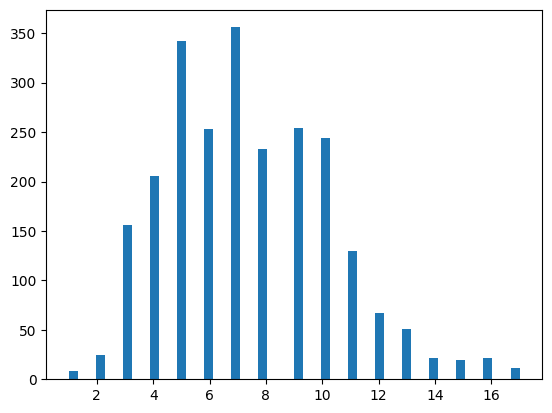

In [27]:
# Построение гистограммы распределения длин текстов в словах основного набора
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

In [28]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 1600
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(1920, 1600) (480, 1600)


И посмотрите на обучение модели *Embedding + Dense* на обновленной базе:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2575 - loss: 2.2607 - val_accuracy: 0.2500 - val_loss: 1.4055
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2311 - loss: 1.6316 - val_accuracy: 0.2500 - val_loss: 1.4346
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2592 - loss: 1.5283 - val_accuracy: 0.2500 - val_loss: 1.4260
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2910 - loss: 1.4803 - val_accuracy: 0.2500 - val_loss: 1.4266
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3156 - loss: 1.4215 - val_accuracy: 0.2500 - val_loss: 1.4220
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4274 - loss: 1.2760 - val_accuracy: 0.3063 - val_loss: 1.3389
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6184 - loss: 0.9497 - val_accuracy: 0.4542 - val_loss: 1.2193
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6519 - loss: 0.8578 - val_accuracy: 0.5063 - val_loss

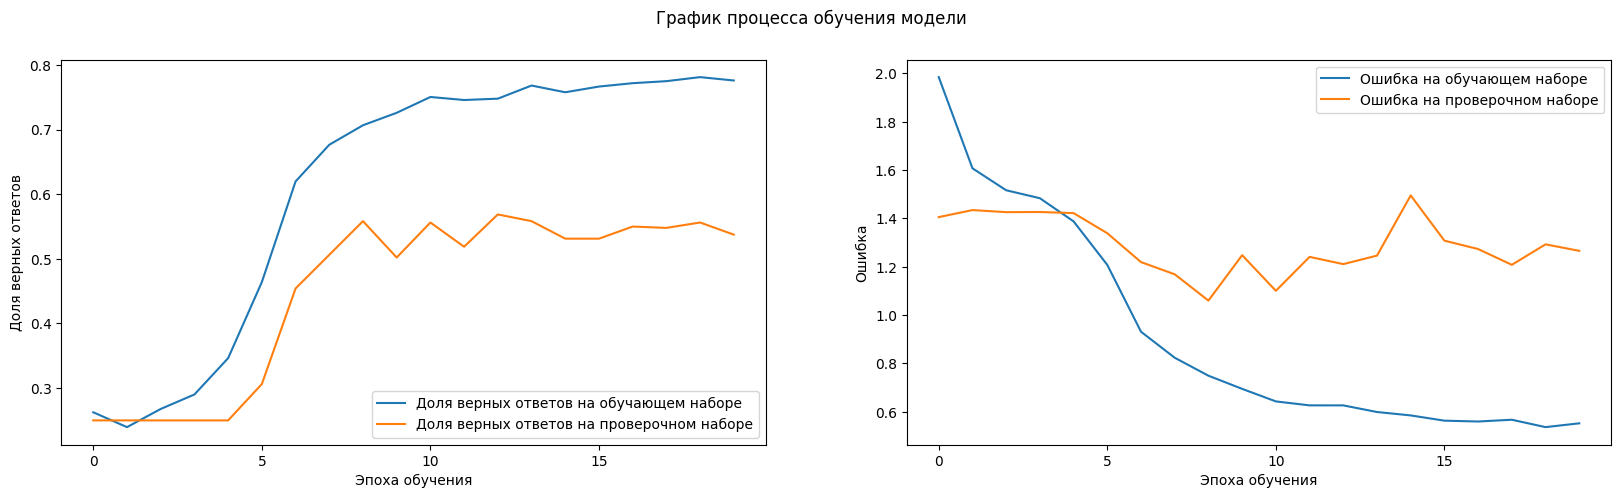

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


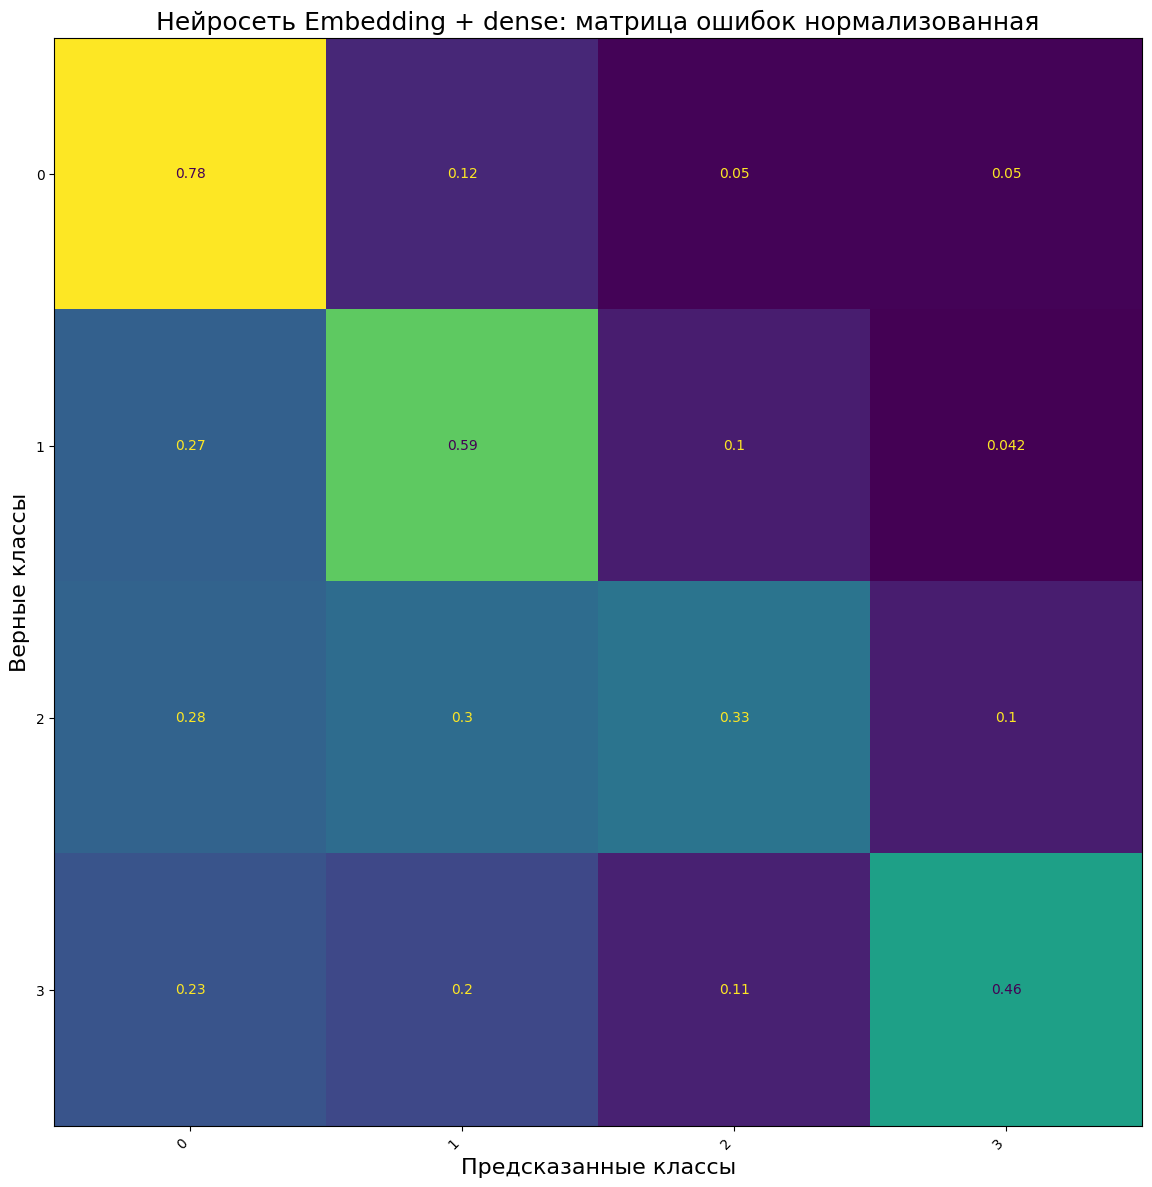

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding + dense
Класс: 0                     78% сеть отнесла к классу 0                    - ВЕРНО :-)
Класс: 1                     59% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 2                     32% сеть отнесла к классу 2                    - ВЕРНО :-)
Класс: 3                     46% сеть отнесла к классу 3                    - ВЕРНО :-)

Средняя точность распознавания:  54%


In [29]:
# Последовательная модель
model_text_emb_dense = Sequential()
# Cлой эмбеддингов
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length=seq_max_len))
# Слой регуляризации Dropout
model_text_emb_dense.add(SpatialDropout1D(0.2))
# Cлой преобразования многомерных данных в одномерные
model_text_emb_dense.add(Flatten())
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Полносвязный слой
model_text_emb_dense.add(Dense(64, activation="relu"))
# Слой регуляризации Dropout
model_text_emb_dense.add(Dropout(0.2))
# Слой пакетной нормализации
model_text_emb_dense.add(BatchNormalization())
# Выходной полносвязный слой
model_text_emb_dense.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_dense,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(16, 16),
                         class_labels=CLASS_LIST,
                         title='Embedding + dense')

**Выводы по обучению модели Embedding + Dense на обновленной базе**

1. Точность на обучающей выборке росла, ошибка сети падала. Но проверочный
набор снова сообщил о вялотекущем прогрессе: точность едва ли росла, да и
ошибка не показала тенденции на понижение.
2. График-матрица ошибок продемонстрировал, что НС еле-еле научилась
предсказывать категории «Дороги и транспорт», «Здравоохранение» и «ЖКХ».
3. Средняя точность работы сети составила 31%, что вдвое выше точности той же
модели в первом эксперименте. Но это все равно плохой результат (оценка
«неудовлетворительно»).

### Итоги экспериментов

В обработке базы обращений граждан наилучший результат показала полносвязная сеть
*Bag Of Words*. Но не стоит недооценивать *Embedding*: использование данного слоя в НС
просто не подошло под конкретный тип задачи. Есть ряд задач, где *Embedding*, напротив,
справится лучше, чем *Bag Of Words*. Учитывайте, какую большую роль играет качество
базы данных в обучении: после фильтрации и балансировки исходной базы вы увеличили
точность работы НС более, чем в 2 раза.

> Важно: предложенный в данном блокноте способ выравнивания
(балансировки) данных – не единственный и не самый лучший.
Разработано довольно много способов балансировки данных, включая
аугментацию. Выбирайте наиболее подходящий способ, исходя из
природы, объема данных, а также из конкретной прикладной задачи.

На этом сегодняшние эксперименты подошли к концу. До новых встреч!